In [10]:
import starspot as SS
ST = SS.Star
SP = SS.Spot

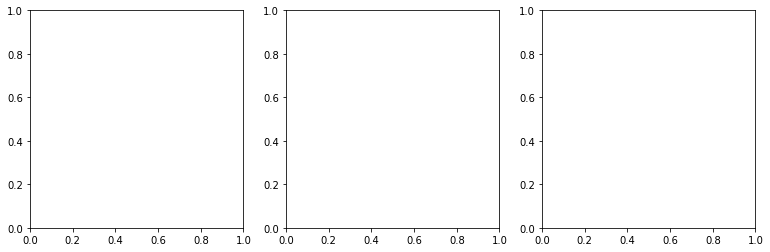

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))
count = 0

In [12]:
def compute_sph(lc, time, rotperiod):
    dt = time[1] - time[0]
    num_grids = int(rotperiod//dt)
    count = 0
    sph = []
    sph_time = []
    while (count+1)*num_grids < len(time):
        sph.append(np.std(lc[count*num_grids:(count+1)*num_grids]))
        sph_time.append(time[count*num_grids])
        count += 1
    return np.array(sph), np.array(sph_time)

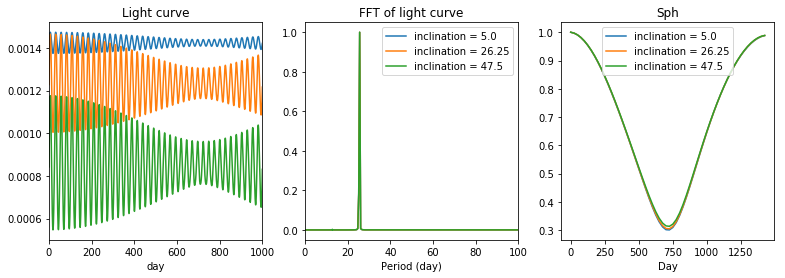

In [15]:
inclination = np.linspace(5, 90, 5)
st1 = ST(inclination=inclination[count], no_evolution=True)
st1.simulate_spots()
st1.compute_light_curve()

light_curve = st1.light_curve
time = st1.time_arr
time = (time - time.min())*365.25

fft_lc, fft_freq = st1.compute_fft(light_curve, time)
fft_period = 1/fft_freq

sph, sph_time = compute_sph(light_curve, time, 25)


axs[0].plot(time, light_curve)
axs[0].set_xlim([0, 1000])
axs[0].set_xlabel('day')
axs[0].set_title('Light curve')

axs[1].plot(fft_period, fft_lc, label=f'inclination = {inclination[count]}')
axs[1].set_xlim([0, 100])
axs[1].set_xlabel('Period (day)')
axs[1].set_title('FFT of light curve')
axs[1].legend()

axs[2].plot(sph_time, sph/sph.max(), label=f'inclination = {inclination[count]}')
axs[2].set_xlabel('Day')
axs[2].set_title('Sph')
axs[2].legend()
count += 1
fig

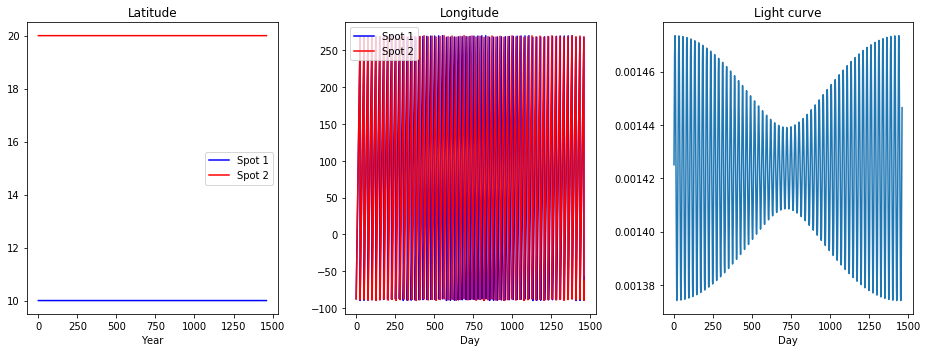

In [5]:
time1 = st1.spot_dict['1']['time']
time1 = (time1 - time1.min())*365.25

time2 = st1.spot_dict['2']['time']
time2 = (time2 - time2.min())*365.25

lat1 = np.degrees(st1.spot_dict['1']['latitude'])
lat2 = np.degrees(st1.spot_dict['2']['latitude'])

lon1 = np.degrees(st1.spot_dict['1']['longitude'])
lon2 = np.degrees(st1.spot_dict['2']['longitude'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))
flataxs = axs.flatten()
flataxs[0].plot(time1, lat1, 'b', label='Spot 1')
flataxs[0].plot(time2, lat2, 'r', label='Spot 2')
#flataxs[0].set_xlabel('Year')
flataxs[0].set_xlabel('Year')
flataxs[0].set_title('Latitude')
flataxs[0].legend()

flataxs[1].plot(time1, lon1, 'b', label='Spot 1')
flataxs[1].plot(time2, lon2, 'r', label='Spot 2')
#flataxs[1].set_xlabel('Year')
flataxs[1].set_xlabel('Day')
flataxs[1].set_title('Longitude')
flataxs[1].legend()

flataxs[2].plot(time, light_curve)
flataxs[2].set_title('Light curve')
#flataxs[2].set_xlabel('Year')
flataxs[2].set_xlabel('Day')
fig.tight_layout()
plt.show()




In [6]:
len(st1.spot_dict['1']['longitude'])

8766

In [7]:
areas = st1.spot_dict['1']['area']
maxlats = np.arcsin(np.sqrt(areas/np.pi)/SS.rsun)
spotref_lats = np.linspace(0, maxlats, st1.spotref_latnum)[:, SS.NAX, :]
spotref_lons = st1.spotref_longitudes[SS.NAX, :, SS.NAX]
starref_lat, starref_lon = st1.convert_to_starref(spotref_lats, spotref_lons, st1.spot_dict['1']['latitude'][SS.NAX, SS.NAX, :])
print(starref_lat.shape)


(10, 30, 8766)


In [ ]:
st1.spot_dict['6']['time'] - SS.initial_time

## How does beating modulate light curve?

In [83]:
from scipy.signal import savgol_filter as savgol

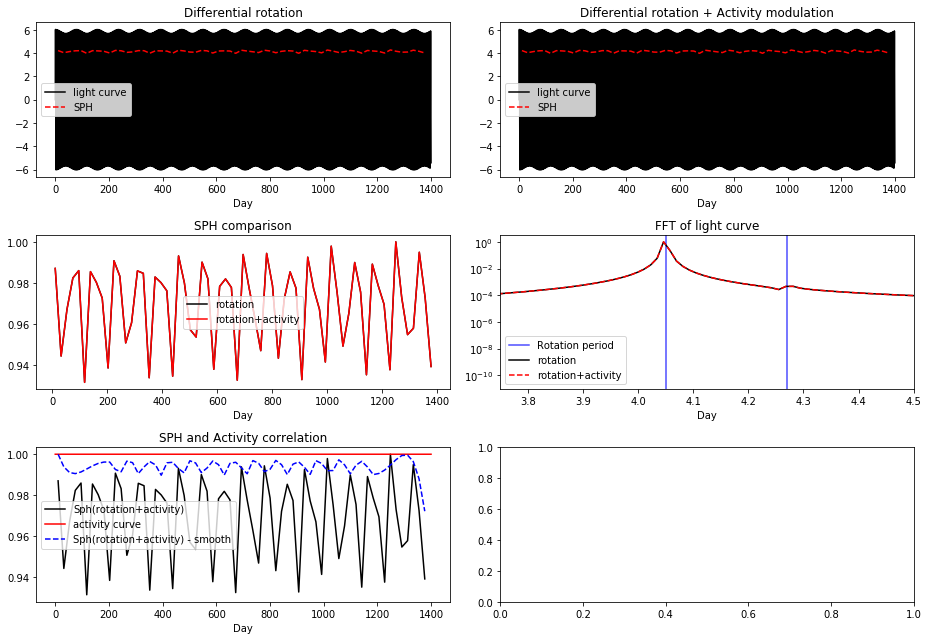

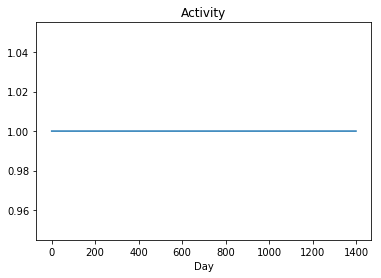

In [85]:
def compute_sph(sig, box_size):
    len_sig = len(sig)
    num_boxes = int(len_sig // box_size)
    sph = np.zeros(num_boxes, dtype=np.float64)
    t_sph = np.zeros(num_boxes, dtype=np.float64)
    start_idx = 0
    end_idx = 0
    for ib in range(num_boxes):
        end_idx = int(start_idx + box_size)
        sph[ib] = np.std(sig[start_idx:end_idx])
        t_sph[ib] = t[int((start_idx+end_idx)//2)]
        start_idx = int(end_idx)
    return sph, t_sph

def compute_fft(sig):
    fft_sig = np.fft.fft(sig)
    fft_freq = np.fft.fftfreq(len(sig), d=dt)
    mask_pos = fft_freq > 0
    fft_freq = fft_freq[mask_pos][1:]
    fft_sig = abs(fft_sig[mask_pos][1:])**2
    time_period = 1/fft_freq
    fft_sig /= fft_sig.max()
    return fft_sig, time_period, fft_freq

def gumbel(x, mu, beta, thintail=False):
    g = np.exp(-(x-mu)/beta) * np.exp(-np.exp(-(x-mu)/beta))/beta
    if thintail:
        return g[::-1]
    else:
        return g

def periodic_gumbel(x, mu, beta, thintail=False):
    g = gumbel(x, mu, beta, thintail=thintail)
    g_periodic = g*1.0
    gmax = g.max()
    g10 = gmax/10.
    sign_diff = np.sign(g-g10)
    g10_idxs = np.where((sign_diff[1:] * sign_diff[:-1]) < 0)[0]
    g10_idx_min = g10_idxs[0]
    g10_idx_max = g10_idxs[1]
    g_periodic[:g10_idx_min] = g[g10_idx_max-g10_idx_min:g10_idx_max]
    g_periodic[g10_idx_max:] = g[g10_idx_min:g10_idx_min+len(g)-g10_idx_max]
    # g_periodic = savgol(g_periodic, 3001, 5)
    return g_periodic/g_periodic.max()
    
    

t = np.linspace(0, 1400, 200000)
dt = t[1] - t[0]
T1, T2, T3 = 4.05, 4.27, 4.05
#T1, T2, T3 = 9.83, 10.2, 9.83
A1, A2, A3 = 5, 0.17, np.sqrt(3)/2
rot_period = max(T1, T2, T3)
prot_boxsize = 5*rot_period/dt
num_boxes = int(len(t)//prot_boxsize)

Tactivity2 = 1.6*365.25
signal1 = A1*np.sin(2*np.pi*t/T1)
signal2 = A2*np.sin(2*np.pi*t/T2)
signal3 = A3*np.sin(2*np.pi*t/T3)

activity_modulation = np.sin(2*np.pi*t/Tactivity2 + 0.76)**4
activity_modulation = periodic_gumbel(t, 240, Tactivity2/4, thintail=True)
activity_modulation = np.ones_like(t)
signal_total1 = (signal1 + signal2 + signal3)*1.0
signal_total2 = (signal1 + signal2 + signal3)*1.0*activity_modulation

fft_totsignal1, fft_periods1, freq1 = compute_fft(signal_total1)
fft_totsignal2, fft_periods2, freq2 = compute_fft(signal_total2)

sph1, t_sph1 = compute_sph(signal_total1, prot_boxsize)
sph2, t_sph2 = compute_sph(signal_total2, prot_boxsize)

dt_sph = prot_boxsize*dt
window = int(400/dt_sph)
if window%2 == 0: window += 1
sph2_smooth = savgol(sph2, window, 5)


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13, 9))
flataxs = axs.flatten()
flataxs[0].plot(t, signal_total1, 'k', label='light curve')
flataxs[0].plot(t_sph1, sph1, '--r', label='SPH')
flataxs[0].legend()
flataxs[0].set_xlabel('Day')
flataxs[0].set_title('Differential rotation')

flataxs[1].plot(t, signal_total2, 'k', label='light curve')
flataxs[1].plot(t_sph2, sph2, '--r', label='SPH')
flataxs[1].legend()
flataxs[1].set_xlabel('Day')
flataxs[1].set_title('Differential rotation + Activity modulation')

flataxs[2].set_title('SPH comparison')
flataxs[2].plot(t_sph1, sph1/sph1.max(), 'k', label='rotation')
flataxs[2].plot(t_sph2, sph2/sph2.max(), 'r', label='rotation+activity')
flataxs[2].set_xlabel('Day')
flataxs[2].legend()

flataxs[3].axvline(x=T1, color='blue', alpha=0.7, label='Rotation period')
flataxs[3].axvline(x=T2, color='blue', alpha=0.7)
flataxs[3].semilogy(fft_periods1, fft_totsignal1, 'k', label='rotation')
flataxs[3].semilogy(fft_periods2, fft_totsignal2, '--r', label='rotation+activity')
flataxs[3].set_xlim([3.75, 4.5])
flataxs[3].set_xlabel('Day')
flataxs[3].set_title('FFT of light curve')
flataxs[3].legend()


flataxs[4].plot(t_sph2, sph2/sph2.max(), 'k', label='Sph(rotation+activity)')
flataxs[4].plot(t, activity_modulation, 'r', label='activity curve')
flataxs[4].plot(t_sph2, sph2_smooth/sph2_smooth.max(), '--b', label='Sph(rotation+activity) - smooth')
flataxs[4].set_xlabel('Day')
flataxs[4].set_title('SPH and Activity correlation')
flataxs[4].legend()

fig.tight_layout()
plt.show(fig)

plt.figure()
plt.plot(t, activity_modulation)
plt.title('Activity')
plt.xlabel('Day')
plt.show()



In [ ]:
from scipy.signal import find_peaks

In [ ]:
peak_freqs1 = freq1[find_peaks(fft_totsignal1)[0]]
peak_freqs2 = freq1[find_peaks(fft_totsignal2)[0]]

In [ ]:
def get_central_freqs(freqs):
    cen_freqs = []
    len_freqs = len(freqs)
    for i in range(len_freqs):
        for ii in range(i+1, len_freqs):
            cen_freqs.append((freqs[i]+freqs[ii])/2)
    return np.array(cen_freqs)

In [ ]:
cen_freqs1 = get_central_freqs(peak_freqs1)
cen_freqs2 = get_central_freqs(peak_freqs2)
print(cen_freqs1, peak_freqs1)

In [ ]:
plt.hist(cen_freqs1, bins=freq2[(freq2>0.15)*(freq2<0.35)])

## Using autocorrelation to determine period

In [ ]:
t = np.linspace(0, 10, 1000)
sint = np.sin(2*np.pi*t/1.3) + 3*np.sin(2*np.pi*t/3.0)
sint /= sint.max()
autocorr = np.correlate(sint, sint, mode='full')
autocorr /= autocorr.max()
plt.plot(t, autocorr[len(t)-1:])
plt.plot(t, sint, 'r')

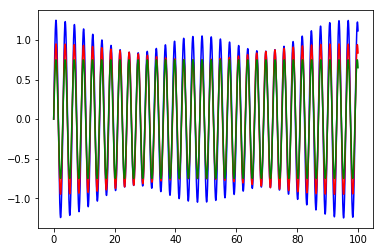

In [98]:
t = np.linspace(0, 100, 10000)
a1 = np.sin(2*np.pi*t/3)
a2 = 0.1*np.sin(2*np.pi*t/3.1)
a3 = 0.15*np.sin(2*np.pi*t/3.2)
a = a1 + a2 + a3
plt.plot(t, a, 'b')
plt.plot(t, 0.85*a1 + a2, 'r') 
plt.plot(t, 0.75*a1, 'g')